出自《战国策·齐策三》一众所周知的名句：“物以类聚，人以群分”，用于比喻同类的东西常聚在一起，志同道合的人相聚成群，其中亦包含的“用户分群”这一思想。近年来，电商行业蓬勃发展，用户流量无疑是立足之本。如何获取流量并减少用户流失、挖掘现有用户的价值，提高精细化运营至关重要。

用户分群，即基于不同维度，将用户为不同的群体。针对不同的群体，采取不同的策略，进而最大化地挖掘用户价值。

基于英国工艺品线上零售数据，即从2010年12月1日至2011年12月9日期间发生的所有交易记录，且该零售商的大部分客户为批发商。通过对其交易进行数据分析，可对其客户特征及销售特征进行刻画，从而可提高销量，降低退货率。

案例数据集选自Kaggle——(https://www.kaggle.com/carrie1/ecommerce-data)

# 理解数据

In [182]:
#忽略警告提示
import warnings
warnings.filterwarnings('ignore')

#导入处理数据包
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#导入数据
dataset = pd.read_excel("./Online Retail.xlsx")
print ('数据集:',dataset.shape)

数据集: (541909, 8)


数据集共有541909条数据，8个字段，具体描述了2010年12月1日至2011年12月9日内英国线上零售商城的所有交易信息。

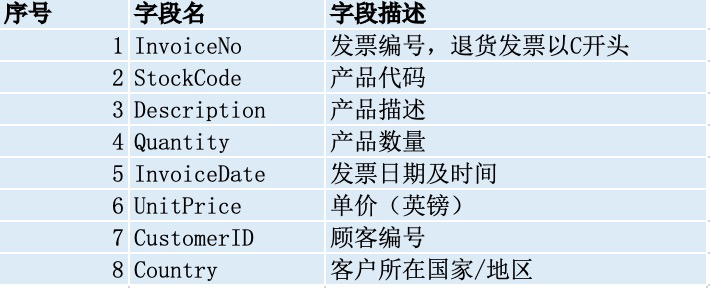

# 数据清洗 

## 删除缺失值

In [184]:
print ('缺失值数量:\n',dataset.isnull().sum())
print(" ")
print ('缺失值占比:\n',dataset.isnull().sum()/dataset.shape[0])

缺失值数量:
 InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64
 
缺失值占比:
 InvoiceNo      0.000000
StockCode      0.000000
Description    0.002683
Quantity       0.000000
InvoiceDate    0.000000
UnitPrice      0.000000
CustomerID     0.249267
Country        0.000000
dtype: float64


由此可见，数据集中的Description和CustomerID这两个变量存在缺失值，且CustomerID缺失比较严重，占比约为24.9%。Description缺失相对较少且非关键信息，可以忽略。对于CustomerID的大量缺失，选择删除全部缺失值。

In [185]:
dataset.dropna(subset=["CustomerID"],inplace=True)

## 处理重复值

In [186]:
dataset.duplicated().sum()

5225

数据集存在5225个重复值。

In [187]:
dataset[dataset.duplicated()==True]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
517,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,2010-12-01 11:45:00,1.25,17908.0,United Kingdom
527,536409,22866,HAND WARMER SCOTTY DOG DESIGN,1,2010-12-01 11:45:00,2.10,17908.0,United Kingdom
537,536409,22900,SET 2 TEA TOWELS I LOVE LONDON,1,2010-12-01 11:45:00,2.95,17908.0,United Kingdom
539,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1,2010-12-01 11:45:00,4.95,17908.0,United Kingdom
555,536412,22327,ROUND SNACK BOXES SET OF 4 SKULLS,1,2010-12-01 11:49:00,2.95,17920.0,United Kingdom
...,...,...,...,...,...,...,...,...
541675,581538,22068,BLACK PIRATE TREASURE CHEST,1,2011-12-09 11:34:00,0.39,14446.0,United Kingdom
541689,581538,23318,BOX OF 6 MINI VINTAGE CRACKERS,1,2011-12-09 11:34:00,2.49,14446.0,United Kingdom
541692,581538,22992,REVOLVER WOODEN RULER,1,2011-12-09 11:34:00,1.95,14446.0,United Kingdom
541699,581538,22694,WICKER STAR,1,2011-12-09 11:34:00,2.10,14446.0,United Kingdom


由上图可知，目前保留的这些字段其重复值都是有含义的，InvoiceNo（交易编码）重复是因为将同一消费者一次购买的多个商品拆分为多条数据，StockCode（产品号码）重复是表明多次被购买。

因此，不删除重复值。

## 处理异常值

In [188]:
#剔除掉非商品的订单
dataset[dataset["StockCode"].str.contains(r"^[a-zA-Z]+")==True]["StockCode"].unique()

array(['POST', 'D', 'C2', 'M', 'BANK CHARGES', 'PADS', 'DOT', 'CRUK'],
      dtype=object)

StockCode主要由数字构成，但其中有英文构成的，经过检查发现是商品产生的附加费用，如邮费、人工费、慈善捐赠等，这部分不是商品，先进行剔除。

In [189]:
print("非正常订单数量：",dataset[(dataset["Quantity"]<=0) | (dataset["UnitPrice"]<=0)]["InvoiceNo"].count())
print("已取消订单数量：",dataset[dataset["InvoiceNo"].str.contains("C")==True].shape[0])
print("单价为0订单数量：",dataset[dataset["UnitPrice"]==0].shape[0])

非正常订单数量： 8945
已取消订单数量： 8905
单价为0订单数量： 40


由此可见，除已取消订单外，有40条数据是UnitPrice为0的情况。即订单形成，但是订单金额为0，考虑这些店家可能存在刷单行为。
因此这些也属于异常值范围，需要删除。

In [190]:
dataset = dataset[~(dataset['StockCode'].str.contains(r"^[a-zA-Z]+")==True)]
data_canceled = dataset[dataset["InvoiceNo"].str.contains("C")==True]
dataset = dataset[~((dataset["Quantity"]<=0) | (dataset["UnitPrice"]<=0))]
print("数据清洗后，已取消订单行列数：",data_canceled.shape)
print("数据清洗后，成功交易的订单行列数为：",dataset.shape)

数据清洗后，已取消订单行列数： (8539, 8)
数据清洗后，成功交易的订单行列数为： (396337, 8)


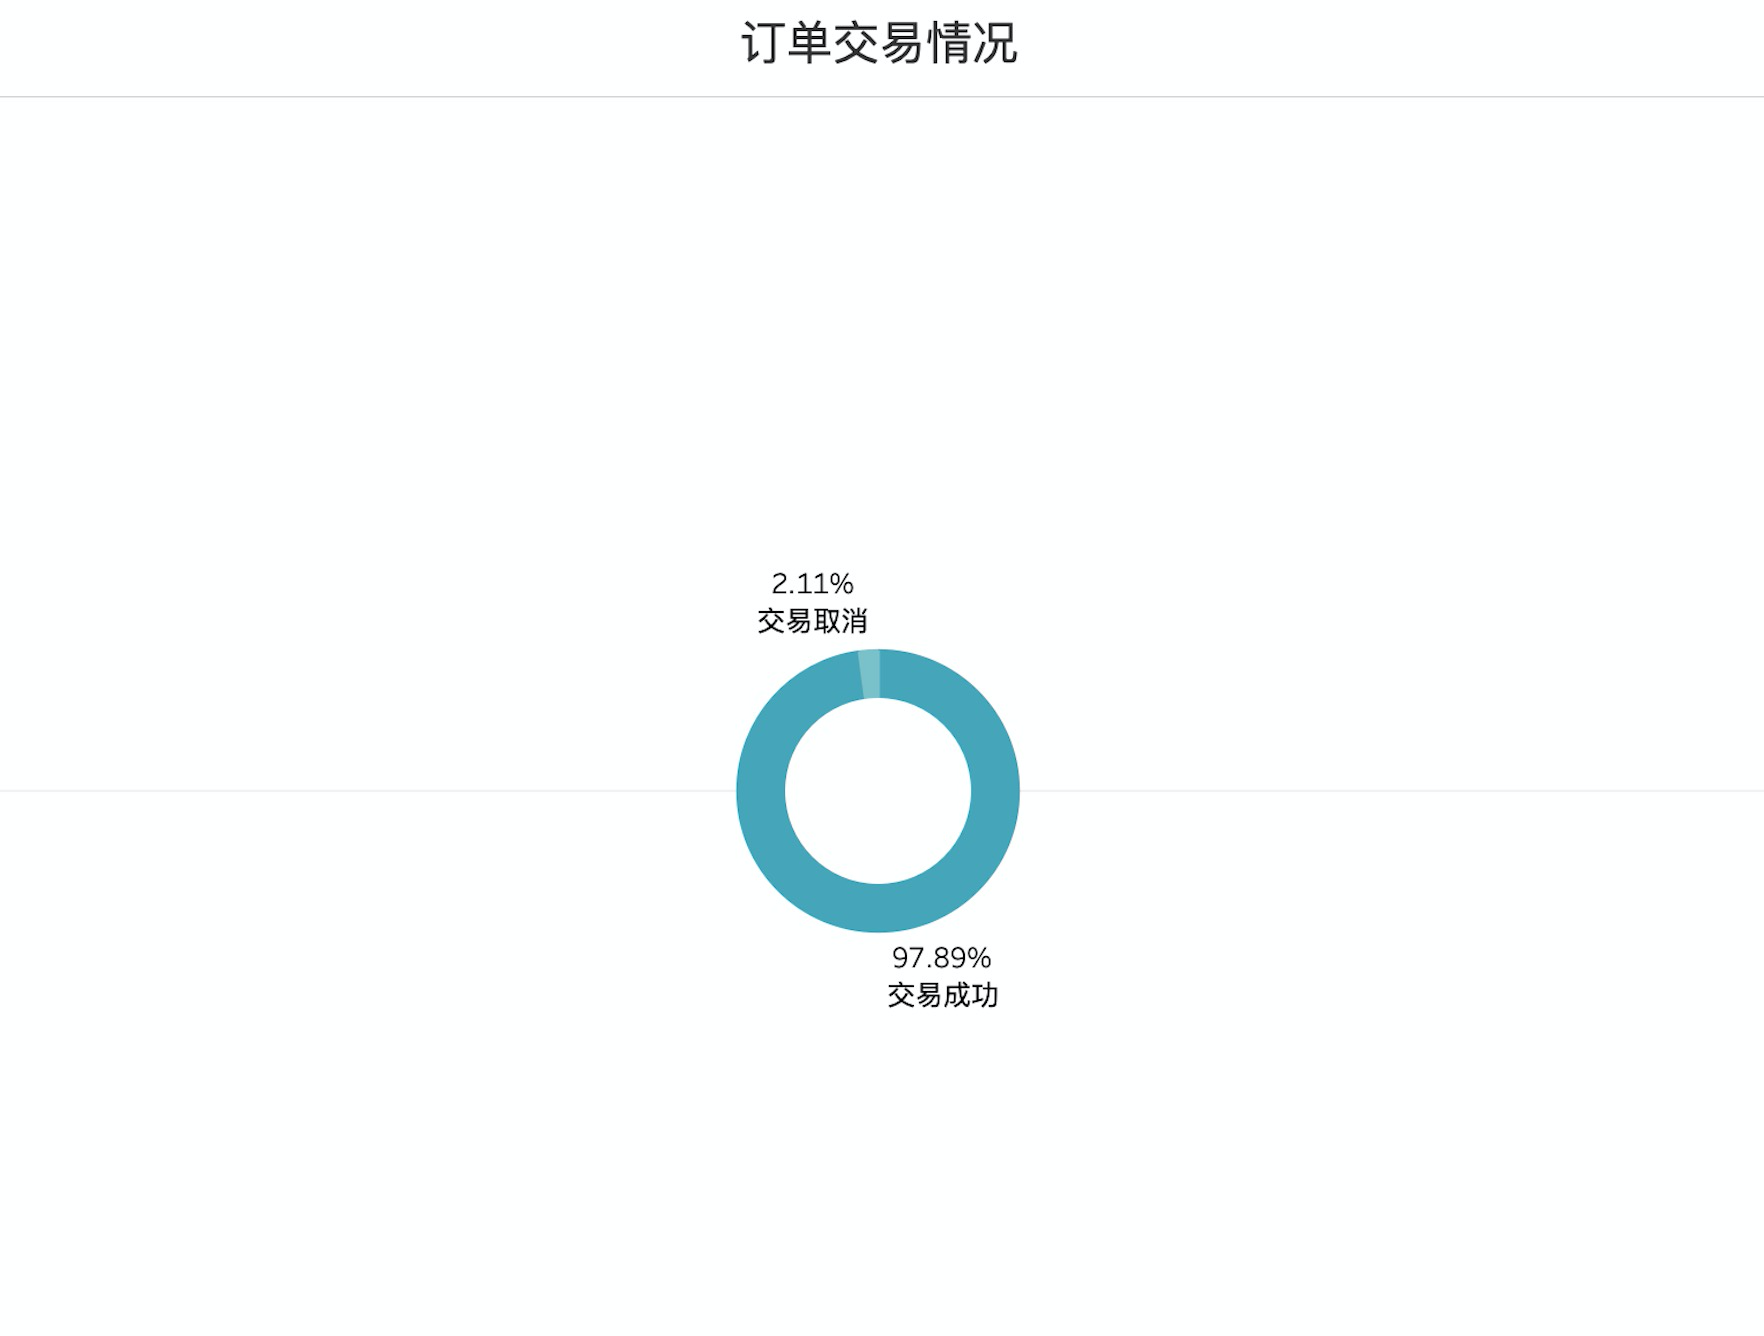

# 数据分析

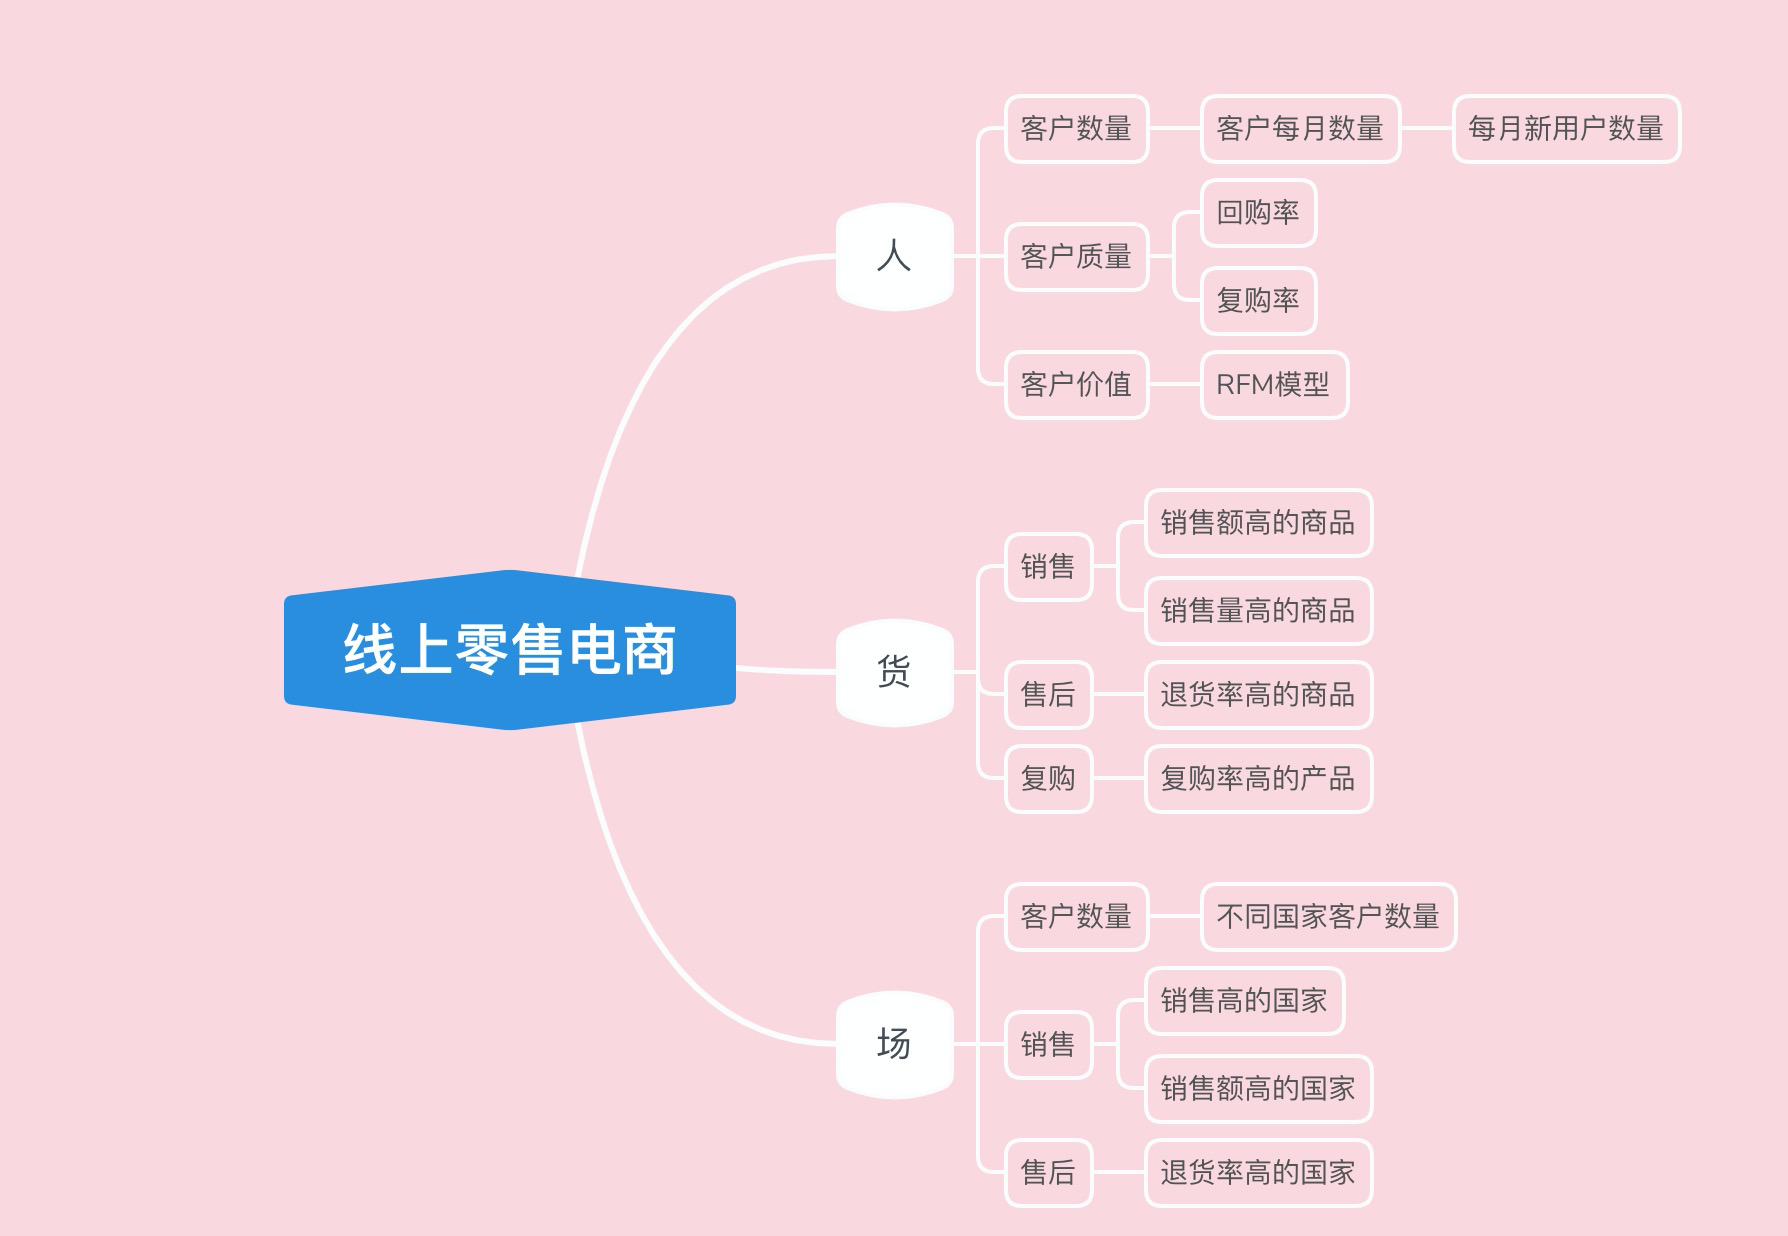

在电商行业，人-货-场是三个永恒不变的组成要素，因此将主要从这三个维度进行分析，并解决以下问题：

1. 人：用户消费行为分析

    客户数量、新客户数量
    
    复购率、回购率
    
    用户分层
    
    RFM模型构建
    
    
2. 货：产品交易趋势分析
    
    销售额、销量
    
    退货率、复购率
     
    
3. 场：消费趋势分析

    客户数量、销量、销售额、退货率
    

## 客户

### 客户数量

In [191]:
dataset["CustomerID"].nunique(),dataset["InvoiceNo"].nunique(),dataset["StockCode"].nunique()

(4334, 18402, 3659)

数据集共涉及4334名顾客、3659种产品，18402个订单。

In [192]:
a = dataset.groupby(dataset["InvoiceDate"].dt.to_period("M")).agg(Customer_num=("CustomerID",lambda x : x.nunique())).reset_index()
from pyecharts import options as opts
from pyecharts.charts import Bar
bar = (
    Bar()
    .add_xaxis(a["InvoiceDate"].dt.strftime("%Y-%m").to_list())
    .add_yaxis("每月客户数量", a["Customer_num"].to_list())
    .set_global_opts(title_opts=opts.TitleOpts(title="商品销量对比图"),
                  datazoom_opts=opts.DataZoomOpts(type_="inside"))
)
bar.render_notebook()

从上图可看出：

（1）从2011年9月开始到同年11月，客户数量增长较明显，但在12月份数量却骤减，可能与11月份的促销活动有关。

（2）如果相应的历史数据也具有以上特征，则可认为8月底是全年中产品上新的较好时机。

### 新客户数量

In [193]:
customers_seen = []
new_customers = []
for month in dataset["InvoiceDate"].dt.to_period('M').unique():
    customers = dataset[dataset["InvoiceDate"].dt.to_period('M') == month].CustomerID.unique()
    count = 0
    for cus in customers:
        if cus not in customers_seen:
            count +=1 
            customers_seen.append(cus)
    new_customers.append((month.strftime("%Y-%m"),count))    
new_customers

[('2010-12', 884),
 ('2011-01', 416),
 ('2011-02', 380),
 ('2011-03', 452),
 ('2011-04', 300),
 ('2011-05', 284),
 ('2011-06', 242),
 ('2011-07', 187),
 ('2011-08', 169),
 ('2011-09', 299),
 ('2011-10', 357),
 ('2011-11', 323),
 ('2011-12', 41)]

In [194]:
from pyecharts.charts import Line
new = pd.DataFrame(new_customers,columns=["date","new_customers"]) 
df_concat = pd.concat([a,new],axis=1)
c = (
    Line()
    .add_xaxis(df_concat["InvoiceDate"].dt.strftime("%Y-%m").to_list())
    .add_yaxis("新用户数量", df_concat["new_customers"].to_list())
    .add_yaxis("总用户数量", df_concat["Customer_num"].to_list())
    .set_global_opts(title_opts=opts.TitleOpts(title="总用户 vs 新用户数量"))
)
c.render_notebook()

由上图可见：

（1）新客户的数量整体上呈下降趋势，但造成这样结果的原因可能是我们没有足够的历史数据。

（2）从2010年8月开始，客户增长的数量高于新客户的数量，说明部分老用户已被唤醒。


### 客户复购率

In [195]:
#创建新变量：销售额 =销量 * 单价
dataset["TotalPrice"] = dataset["Quantity"]*dataset["UnitPrice"]

In [196]:
d1 = dataset.copy()
d1["date"] = d1["InvoiceDate"].dt.strftime("%Y-%m")
customer_repurchase = d1.groupby(["CustomerID","date"])[["InvoiceNo"]].nunique().reset_index()
cr1 = customer_repurchase.groupby("date")["InvoiceNo"].count().reset_index()
cr2 = customer_repurchase[customer_repurchase["InvoiceNo"]>1].groupby("date")["InvoiceNo"].count().reset_index()
cr_merge = pd.merge(cr1,cr2,on="date")
cr_merge["ratio"] = cr_merge["InvoiceNo_y"]/cr_merge["InvoiceNo_x"]*100

In [197]:
from pyecharts.charts import Line
c = (
    Line()
    .add_xaxis(cr_merge["date"].to_list())
    .add_yaxis("客户复购率", cr_merge["ratio"].to_list(),label_opts = opts.LabelOpts(is_show=False))#="{@[1]}%"))
    .set_global_opts(title_opts=opts.TitleOpts(title="客户复购率"))
)
c.render_notebook()

由上图可知，全年每月的用户复购率均在19%以上，在5月份以及双十一年底由于节日的推动更是接近40%，总体客户质量较高。

### 客户回购率

In [198]:
#回购率
import datetime
def astype_date(x):
    year = pd.to_datetime(x["date"]).year
    month = pd.to_datetime(x["date"]).month + 1
     
    if month > 12:
        month =1 
        year +=1 
    #return str(year) + "-" + str(month)
    dd = datetime.datetime(year, month,1)
    return pd.to_datetime(dd).strftime("%Y-%m")

In [199]:
customer_repurchase1 = customer_repurchase.copy()
customer_repurchase1["buyback"] = customer_repurchase.apply(astype_date,axis=1)
customer_repurchase1 = customer_repurchase1.drop("date",axis=1)

In [200]:
add = pd.merge(customer_repurchase, customer_repurchase1,on="CustomerID")
#次月消费人数
next_month = add[add["date"]==add["buyback"]].groupby("date")["CustomerID"].count().reset_index()
month_to_date = customer_repurchase.groupby("date")["CustomerID"].count().reset_index()

In [201]:
buy_back_mer = pd.concat([month_to_date,next_month],axis=1)
buy_back_mer.columns = ["date","month_to_date_num","date1","next_month_num"]
buy_back_mer["ratio"] = buy_back_mer["next_month_num"]/buy_back_mer["month_to_date_num"]*100

In [202]:
c = (
    Line()
    .add_xaxis(buy_back_mer["date"].to_list())
    .add_yaxis("客户回购率", buy_back_mer["ratio"].to_list(),label_opts = opts.LabelOpts(is_show=False))
    .set_global_opts(title_opts=opts.TitleOpts(title="客户回购率"))
)
c.render_notebook()

由上图可知，全年每月用户回购率总体在40%左右，并呈缓慢上升趋势，说明随着时间推进客户忠诚度得到培养，表现为下个月继续在该公司网站购买商品。

### 客户价值

通过RFM模型衡量客户价值，找到最具价值的客户群，以对不同类型的客户进行差异化营销，进而提高企业收益。

RFM模型包含三个分析要素，分别为：

 1. R(Recency):最近一次购买距离现在的时间，值越小价值越大

 2. F(Frequency):某段时间购买次数，越大越好

 3. M(Monetary):某段时间的购买总金额，越大越好

#### 传统RFM模型

    计算R、F、M的值
    给R、F、M按价值打分
    计算价值的平均值，指标得分高于平均值标记为高，反之标记为低
    用户分类规则表比较，得出用户分类

In [203]:
today_date = pd.datetime(2011,12,10)
rfm = dataset.groupby('CustomerID').agg(recency=('InvoiceDate', lambda x: (today_date - x.max()).days),
                                  frequency=('InvoiceNo', lambda x: x.nunique()),
                                  monetary=('TotalPrice',lambda x: x.sum()))

rfm

,recency,frequency,monetary
CustomerID,,,
12346.0,325,1,77183.60
12347.0,2,7,4310.00
12348.0,75,4,1437.24
12349.0,18,1,1457.55
12350.0,310,1,294.40
...,...,...,...
18280.0,277,1,180.60
18281.0,180,1,80.82
18282.0,7,2,178.05


In [204]:
rfm["recency_score"] = pd.qcut(rfm['recency'], 5, labels=[5, 4, 3, 2, 1])
rfm["frequency_score"] = pd.qcut(rfm['frequency'].rank(method="first"), 5, labels=[1, 2, 3, 4, 5])
rfm["monetary_score"] = pd.qcut(rfm['monetary'], 5, labels=[1, 2, 3, 4, 5])
rfm["r"] = rfm["recency_score"].astype(int)
rfm["f"] = rfm["frequency_score"].astype(int)
rfm["m"] = rfm["monetary_score"].astype(int)
r_mean =rfm["r"].mean()
f_mean =rfm["f"].mean()
m_mean =rfm["m"].mean()

In [205]:
#计算价值的平均值，指标得分高于平均值标记为高，反之标记为低
def r(x):
    if x["r"]>r_mean:
        return 1 
    else:
        return 0 

def f(x):
    if x["f"]>r_mean:
        return 1 
    else:
        return 0 

def m(x):
    if x["m"]>r_mean:
        return 1 
    else:
        return 0
rfm["r"] = rfm.apply(r,axis=1)
rfm["f"] = rfm.apply(f,axis=1)
rfm["m"] = rfm.apply(m,axis=1)

In [206]:
rfm.head()

,recency,frequency,monetary,recency_score,frequency_score,monetary_score,r,f,m
CustomerID,,,,,,,,,
12346.0,325,1,77183.60,1,1,5,0,0,1
12347.0,2,7,4310.00,5,5,5,1,1,1
12348.0,75,4,1437.24,2,4,4,0,1,1
12349.0,18,1,1457.55,4,1,4,1,0,1
12350.0,310,1,294.40,1,1,2,0,0,0


客户分层如下，1为高，0为低：

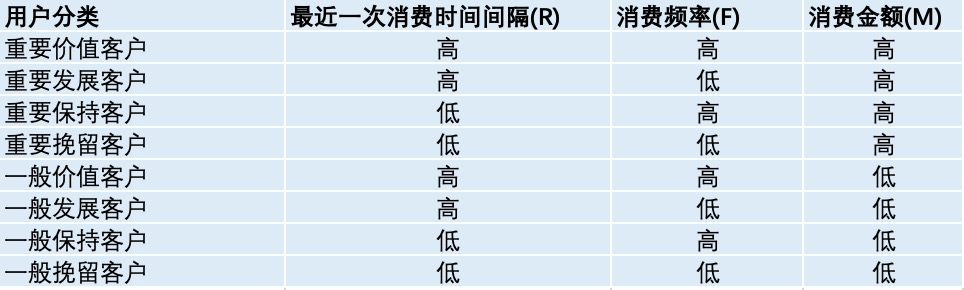

In [207]:
rfm["rfm"]=rfm["r"].astype(str) + rfm["f"].astype(str) + rfm["m"].astype(str)
def rfm_model(x):
    if x == "111":
        return "重要价值客户"
    elif x == "101":
        return "重要发展客户"
    elif x == "011":
        return "重要保持客户"
    elif x == "001":
        return "重要挽留客户"
    elif x == "110":
        return "一般价值客户"
    elif x == "100":
        return "一般发展客户"
    elif x == "010":
        return "一般保持客户"
    elif x == "000":
        return "一般挽留客户"  
rfm["rfm_model"] = rfm["rfm"].apply(rfm_model)
rfm["rfm_model"].value_counts()

一般挽留客户    1719
重要价值客户     949
一般发展客户     512
重要保持客户     416
重要挽留客户     261
一般保持客户     193
一般价值客户     176
重要发展客户     108
Name: rfm_model, dtype: int64

In [208]:
rfm_new = rfm["rfm_model"].value_counts().to_frame().reset_index()
rfm_new.columns = ["customer_type","num"]

In [209]:
from pyecharts.charts import Pie
pie = Pie()
pie.add("",list(zip(rfm_new["customer_type"],rfm_new["num"])))
pie.set_global_opts(
    title_opts=opts.TitleOpts(title="用户分群"),
    legend_opts=opts.LegendOpts(pos_right="bottom")
)
pie.set_series_opts(label_opts=opts.LabelOpts(formatter="{b}: {c}: {d}%"))
pie.render_notebook()

由上图可知，一般挽留用户和重要价值用户占比较大，说明店铺的留存情况仍存在改进空间。因此可制定相关策略，进而提高用户留存率。

1. 重要价值客户：维持现状，重点维护，VIP大用户组织建设是必要的，权益专享、定期福利等；

2. 重要发展客户：提升频次，重点深耕，属于忠诚度不高用户。着力让用户在平台上活跃，优化产品和服务，帮助用户提升频次；

3. 重要保持客户：用户回流，重点挽回，定期的EDM、PUSH、短信，主动和用户保持联系和互动；

4. 重要挽留客户：提前预警，重点召回，属于重点的预流失用户，提前做好预流失预警和策略触达；

5. 一般价值用户：潜力用户，刺激复购，属于重点潜力用户，可以发放大额卡券，引导此类用户不断增加投资；

6. 一般发展用户：多为新用户，挖掘需求，可能是新用户，最近投资过，需要客服回复工作加强，以及福利及时提醒；

7. 一般保持用户：流失召回，属于流失用户，可能产品、服务、奖励力度达不到心里预期，需要做好利益与情感双重触达；

8. 一般挽留用户：可放弃，此类用户流失已久，较难挽回，预算受限的情况下，可以放弃此类用户。

#### Kmeans聚类

In [210]:
df_clustering = rfm[["recency","frequency","monetary"]]
#特征缩放
from sklearn.preprocessing import StandardScaler
std_scaler = StandardScaler()
df_scaled = std_scaler.fit_transform(df_clustering)
df_scaled = pd.DataFrame(df_scaled,columns=['recency', 'frequency', 'monetary'])
df_scaled["CustomerID"] = df_clustering.index

In [211]:
df_scaled = df_scaled.set_index("CustomerID",drop=True)
df_scaled

,recency,frequency,monetary
CustomerID,,,
12346.0,2.323928,-0.425192,8.439044
12347.0,-0.900791,0.360754,0.256951
12348.0,-0.171984,-0.032219,-0.065597
12349.0,-0.741052,-0.425192,-0.063316
12350.0,2.174174,-0.425192,-0.193912
...,...,...,...
18280.0,1.844713,-0.425192,-0.206689
18281.0,0.876299,-0.425192,-0.217892
18282.0,-0.850872,-0.294201,-0.206976


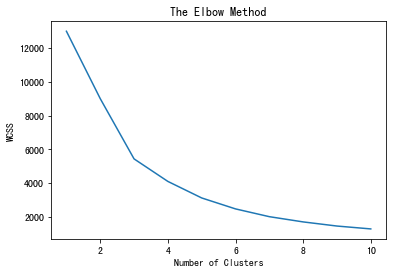

In [212]:
#Kmeans算法
from sklearn.cluster import KMeans
X = df_scaled.values
#手肘法则
wcss = []
for i in range(1,11):
    kmeans = KMeans(n_clusters = i, max_iter = 300, n_init = 10, init = 'k-means++', random_state = 0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
plt.plot(range(1,11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

In [213]:
kmeans = KMeans(n_clusters=4, n_init = 15, random_state=1)
kmeans.fit(df_scaled)
centroids = kmeans.cluster_centers_
centroid_df = pd.DataFrame(centroids, columns = list(df_scaled) )
centroid_df

,recency,frequency,monetary
0,-0.772150,2.328754,1.150195
1,1.556687,-0.354100,-0.173523
2,-0.854712,10.154856,13.904601
3,-0.487490,-0.079293,-0.077568


In [214]:
df_kmeans = df_clustering.copy()
df_labels = pd.DataFrame(kmeans.labels_ , columns = list(['labels']))
df_labels['labels'] = df_labels['labels'].astype('category')
df_kmeans['labels'] = df_labels['labels'].values
df_kmeans

,recency,frequency,monetary,labels
CustomerID,,,,
12346.0,325,1,77183.60,0
12347.0,2,7,4310.00,3
12348.0,75,4,1437.24,3
12349.0,18,1,1457.55,3
12350.0,310,1,294.40,1
...,...,...,...,...
18280.0,277,1,180.60,1
18281.0,180,1,80.82,1
18282.0,7,2,178.05,3


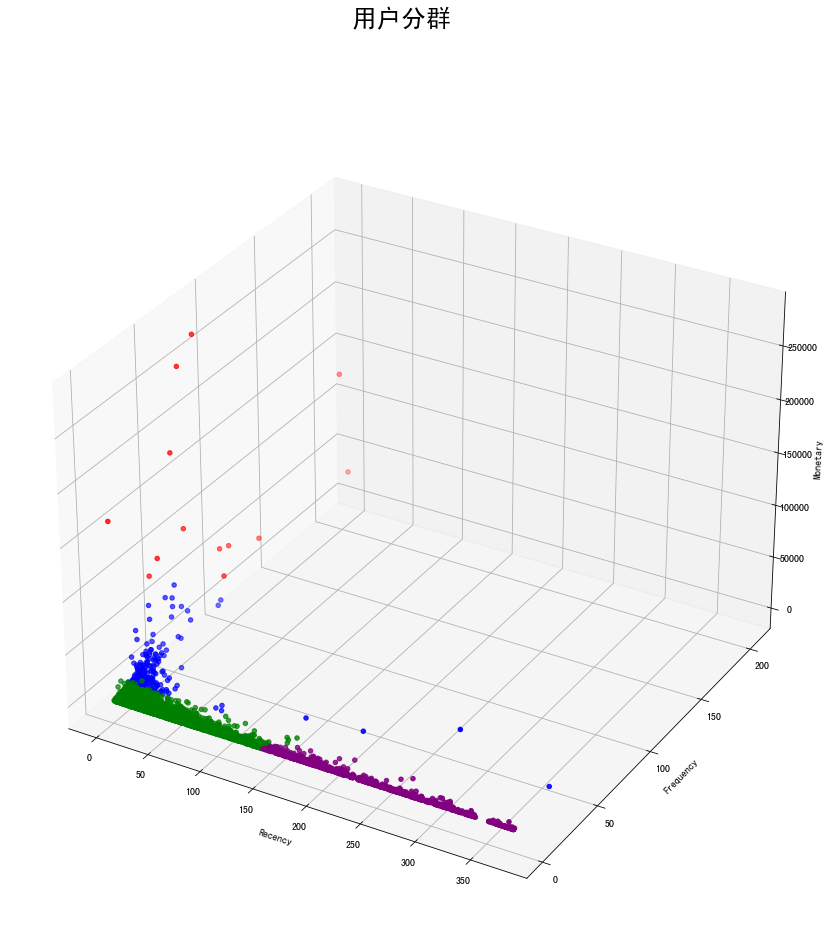

In [215]:
colors = np.array(["blue", "purple","red","green"])
fig  = plt.figure(figsize = (15,15)).suptitle('用户分群', fontsize=25)
ax = plt.axes(projection='3d')
ax.scatter3D(df_kmeans["recency"], df_kmeans["frequency"], df_kmeans["monetary"], marker='o', c=colors[df_kmeans["labels"].tolist()])
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')
#plt.legend()
plt.show()

In [216]:
df_kmeans = df_kmeans.reset_index()
clusters_count = df_kmeans.groupby("labels").agg({"CustomerID": "count"})#不同分组用户数量
clusters_count

,CustomerID
labels,
0,209
1,1065
2,13
3,3047


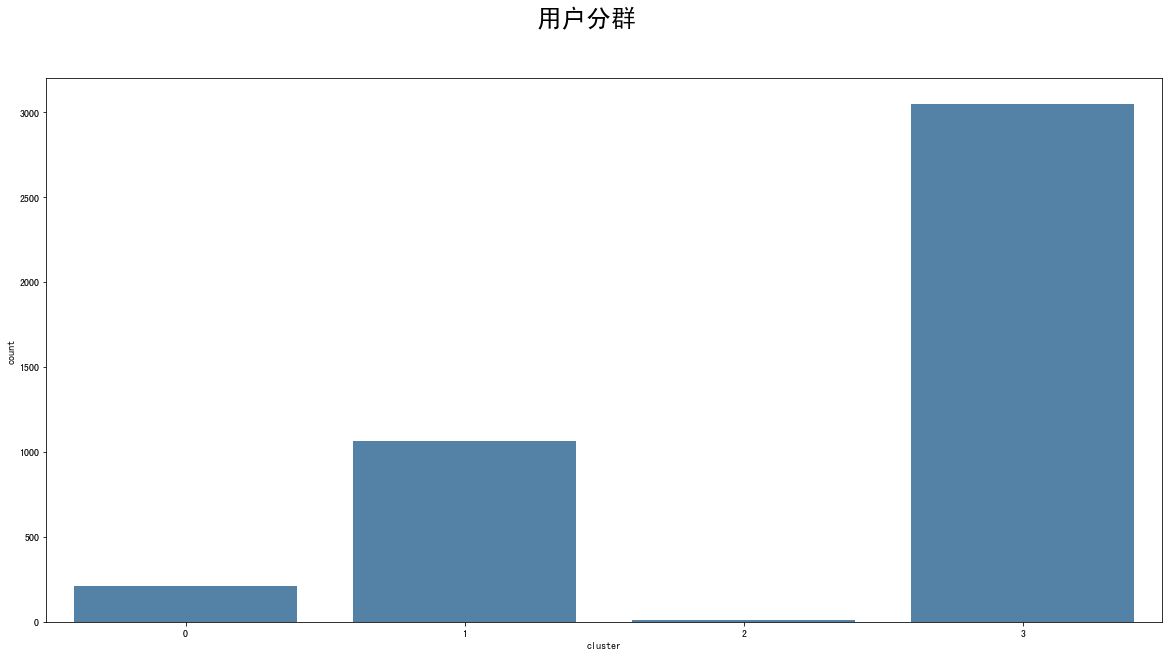

In [217]:
clusters_count.reset_index(inplace=True)
clusters_count.columns = ['cluster', 'count']
fig  = plt.figure(figsize = (20,10)).suptitle('用户分群', fontsize=25)
sns.barplot(data=clusters_count,x=clusters_count["cluster"],y=clusters_count["count"],color="steelblue")

plt.show()

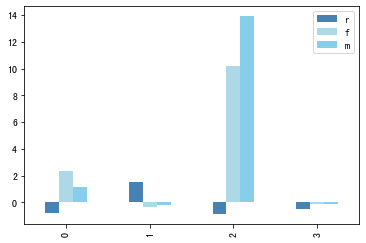

In [218]:
cluster_centers=kmeans.cluster_centers_
cluster_analysis= pd.DataFrame(data=cluster_centers,
                  columns = ['r','f','m']).reset_index(drop= True)
cluster_analysis.plot(kind='bar',color=['steelblue','lightblue',"skyblue"],clip_on=False)
plt.show()

由上图可知：

    第0类客户
    该类客户与第1类客户有很多相似的地方，不同之处在于该类客户仍有购物次数，但不高，为典型的重要挽回客户

    第1类客户
    该类客户上一次购物距今间隔较长，购物频率为0，且购物总金额较少，为典型的流失客户

    第2类客户
    该类客户上一次购物距今间隔较短，购物频率很高，且花费总金额很大，为典型的高价值客户

    第3类客户
    该类客户上一次购物距今间隔较短，购物频率较低，且花费总金额为0，可能为新客户


##  产品

## 按时间划分的销量、销售额和退货率

In [219]:
bb =dataset.groupby(dataset["InvoiceDate"].dt.strftime("%Y-%m"))[["TotalPrice","Quantity"]].sum().reset_index()

In [220]:
from pyecharts import options as opts
from pyecharts.charts import Bar
bar = (
    Bar()
    .add_xaxis(bb["InvoiceDate"].to_list())
    .add_yaxis("销售额", bb["TotalPrice"].to_list(),label_opts = opts.LabelOpts(is_show=False))
    .add_yaxis("销量", bb["Quantity"].to_list(),label_opts = opts.LabelOpts(is_show=False))
    .set_global_opts(title_opts=opts.TitleOpts(title="商品销量 vs 销售额(月)条形图"))
)
bar.render_notebook()

In [221]:
dataset1 = dataset.groupby(dataset["InvoiceDate"].dt.strftime("%Y-%m"))["Quantity"].sum().reset_index()
dc = data_canceled.groupby(data_canceled["InvoiceDate"].dt.strftime("%Y-%m"))["Quantity"].sum().reset_index()
dc["Quantity"] = abs(dc["Quantity"])
ddc_mer = pd.merge(dataset1,dc,on="InvoiceDate")
ddc_mer["ratio"] = ddc_mer["Quantity_y"]/ddc_mer["Quantity_x"]*100
ddc_mer

,InvoiceDate,Quantity_x,Quantity_y,ratio
0,2010-12,311840,15900,5.098769
1,2011-01,348803,79716,22.854161
2,2011-02,265380,2576,0.970684
3,2011-03,348164,3496,1.004124
4,2011-04,291972,13599,4.657638
5,2011-05,373325,4051,1.085114
6,2011-06,363410,6650,1.829889
7,2011-07,369113,5938,1.608721
8,2011-08,397847,11658,2.930272
9,2011-09,544070,7071,1.299649


In [222]:
from pyecharts.charts import Line
Line = (
    Line()
    .add_xaxis(ddc_mer["InvoiceDate"].to_list())
    .add_yaxis("退货率", ddc_mer["ratio"].to_list(),label_opts = opts.LabelOpts(is_show=False))
    .set_global_opts(title_opts=opts.TitleOpts(title="商品退货率"))
)
Line.render_notebook()

从图中可知：

（1）产品销量和销售额在10年12月到11年8月都比较均衡，从9月起到11月逐月增长，到12月大幅度降低；

（2）除11年1月和12月退货率较高外，其他月份退货率基本维持在5%以内，11年12月退货率甚至达到29.1%。

## 按产品分类的销量、销售额和退货量

In [223]:
data_canceled["Quantity"] = data_canceled["Quantity"]*(-1)
dc_new = data_canceled.groupby("StockCode")["Quantity"].sum().reset_index().sort_values(by=["Quantity"],ascending=False)[:10]

In [224]:
sales = dataset.groupby("StockCode")["TotalPrice"].sum().reset_index().sort_values(by=["TotalPrice"],ascending=False)[:10]
bar = (
    Bar()
    .add_xaxis(sales["StockCode"].to_list())
    .add_yaxis("销售额", sales["TotalPrice"].to_list(),label_opts = opts.LabelOpts(is_show=False))
    .set_global_opts(title_opts=opts.TitleOpts(title="销售额排名前10的产品"))
)
bar.render_notebook()

In [225]:
sales_nums = dataset.groupby("StockCode")["Quantity"].sum().reset_index().sort_values(by=["Quantity"],ascending=False)[:10]
bar = (
    Bar()
    .add_xaxis(sales_nums["StockCode"].to_list())
    .add_yaxis("销售量", sales_nums["Quantity"].to_list(),label_opts = opts.LabelOpts(is_show=False))
    .set_global_opts(title_opts=opts.TitleOpts(title="销售量排名前10的产品"))
)
bar.render_notebook()

热卖商品top 10.png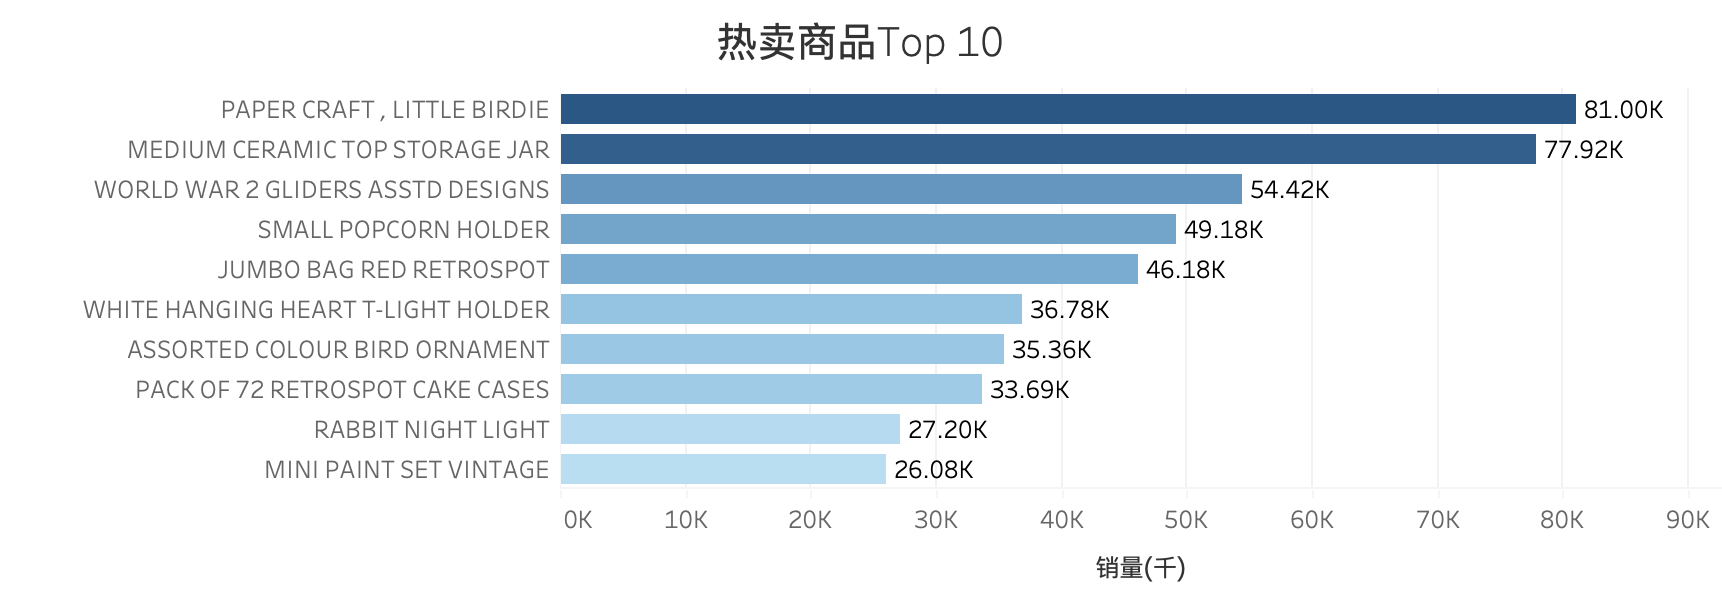

In [226]:
vv = pd.merge(sales[:20],sales_nums,on="StockCode")
#每个产品对应的退货数量
da = data_canceled.groupby("StockCode")["Quantity"].sum().reset_index().sort_values(by="Quantity",ascending=False)
stock_cancel = pd.merge(vv,da,on="StockCode")
stock_cancel["cancel_ratio"]=stock_cancel["Quantity_y"]/stock_cancel["Quantity_x"]*100
stock_cancel = stock_cancel.sort_values(by="cancel_ratio",ascending=False)

In [227]:
bar = (
    Bar()
    .add_xaxis(stock_cancel["StockCode"].to_list())
    .add_yaxis("退货率", stock_cancel["cancel_ratio"].to_list(),label_opts = opts.LabelOpts(is_show=False))
    .set_global_opts(title_opts=opts.TitleOpts(title="退货率排名前5的产品"))
)
bar.render_notebook()

从上图可知：

（1）22423、85123A、85099B、47566、84879、23084等产品的销量、销售额都比较高，退货率较低，可以增大产品的曝光率，进一步提高产品能带来的收益；

（2）23843、23166产品的销量、销售额虽然都较高，但是退货率同样较高，因此可进一步研究此产品的哪些缺点导致退货率高，从而有针对性的进行改进，降低退货率。

## 产品复购率

In [228]:
repurchase_data = dataset.groupby(["StockCode"])["InvoiceNo"].nunique().reset_index()
repurchase = repurchase_data[repurchase_data["InvoiceNo"]>1].sort_values(by=["InvoiceNo"],ascending=False)[:10]

In [229]:
bar = (
    Bar()
    .add_xaxis(repurchase["StockCode"].to_list())
    .add_yaxis("复购率", repurchase["InvoiceNo"].to_list(),label_opts = opts.LabelOpts(is_show=False))
    .set_global_opts(title_opts=opts.TitleOpts(title="复购率排名前10的产品"))
)
bar.render_notebook()

由上图可见，对于复购次数排前10的产品，可增大产品曝光率，进一步扩大销量，增加收益。

## 国家

## 不同国家客户数量

In [230]:
country_customers = dataset.groupby("Country")["CustomerID"].nunique().reset_index().sort_values(by="CustomerID",ascending=False)
pie = Pie()
pie.add("",list(zip(country_customers["Country"][1:],country_customers["CustomerID"][1:])))
pie.set_global_opts(
    title_opts=opts.TitleOpts(title="不同国家客户数量"),
    legend_opts=opts.LegendOpts(pos_right="right")
)
pie.set_series_opts(label_opts=opts.LabelOpts(formatter="{b}: {c}: {d}%"))
pie.render_notebook()

由上图可见，本土用户占比较大，大约为90.19%。其余占比较大的国家分别为德国、法国、西班牙等欧洲国家。因此可以考虑开拓除欧洲以外的其他市场，可能存在较大的市场潜力。

## 不同国家销量、销售额

In [231]:
country_salenum= dataset.groupby("Country")["Quantity"].sum().reset_index().sort_values(by=["Quantity"],ascending=[False])

In [233]:
country_sales = dataset.groupby("Country")["TotalPrice"].sum().reset_index().sort_values(by=["TotalPrice"],ascending=[False])

In [247]:
print("英国销售额占比:",
      country_sales[country_sales["Country"]=="United Kingdom"]["TotalPrice"]
      /country_sales["TotalPrice"].sum())
print("英国销售量占比:",
      country_salenum[country_salenum["Country"]=="United Kingdom"]["Quantity"]
      /country_salenum["Quantity"].sum())

英国销售额占比: 35    0.829335
Name: TotalPrice, dtype: float64
英国销售量占比: 35    0.82397
Name: Quantity, dtype: float64


In [250]:
print("成功交易的国家数量:",dataset["Country"].nunique())

成功交易的国家数量: 37


线上零售-全球订单分布4.png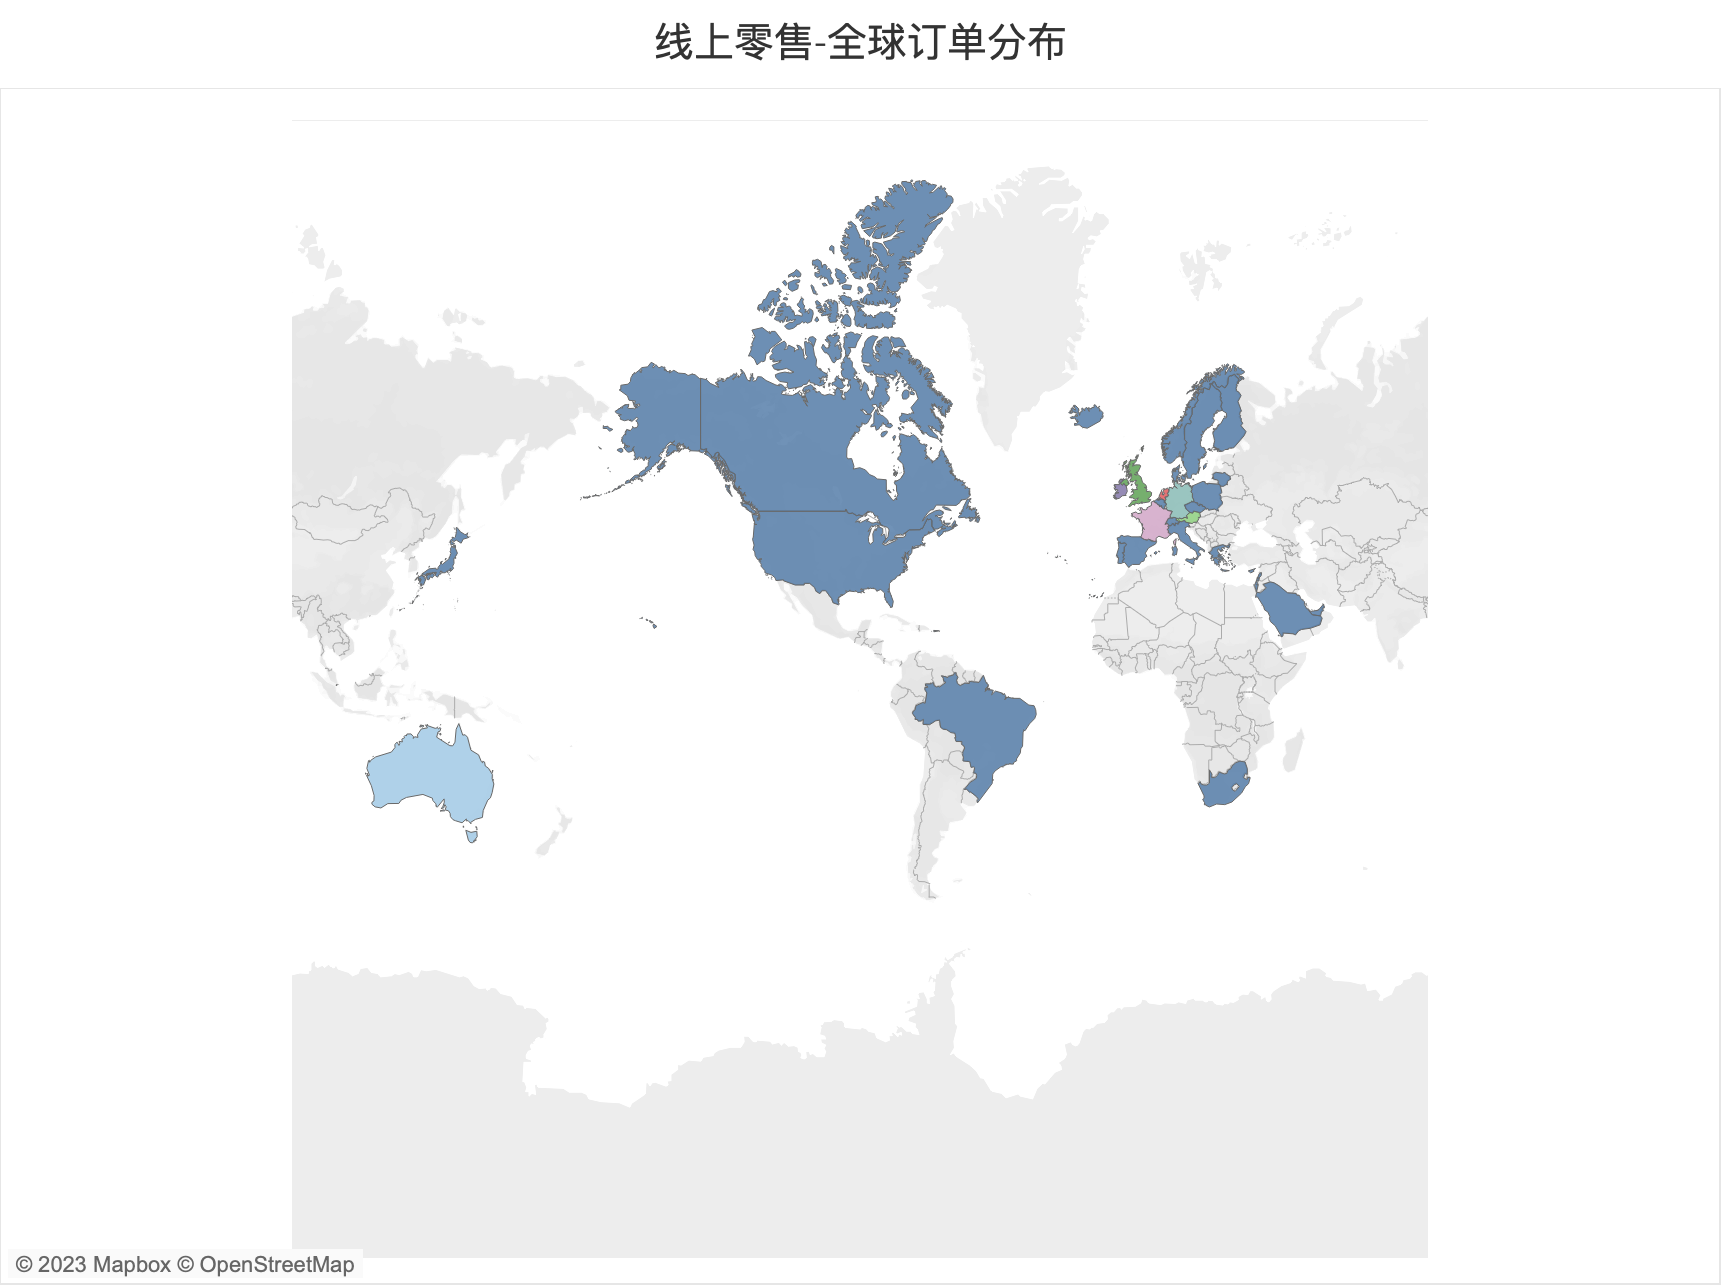

地区消费top 10.png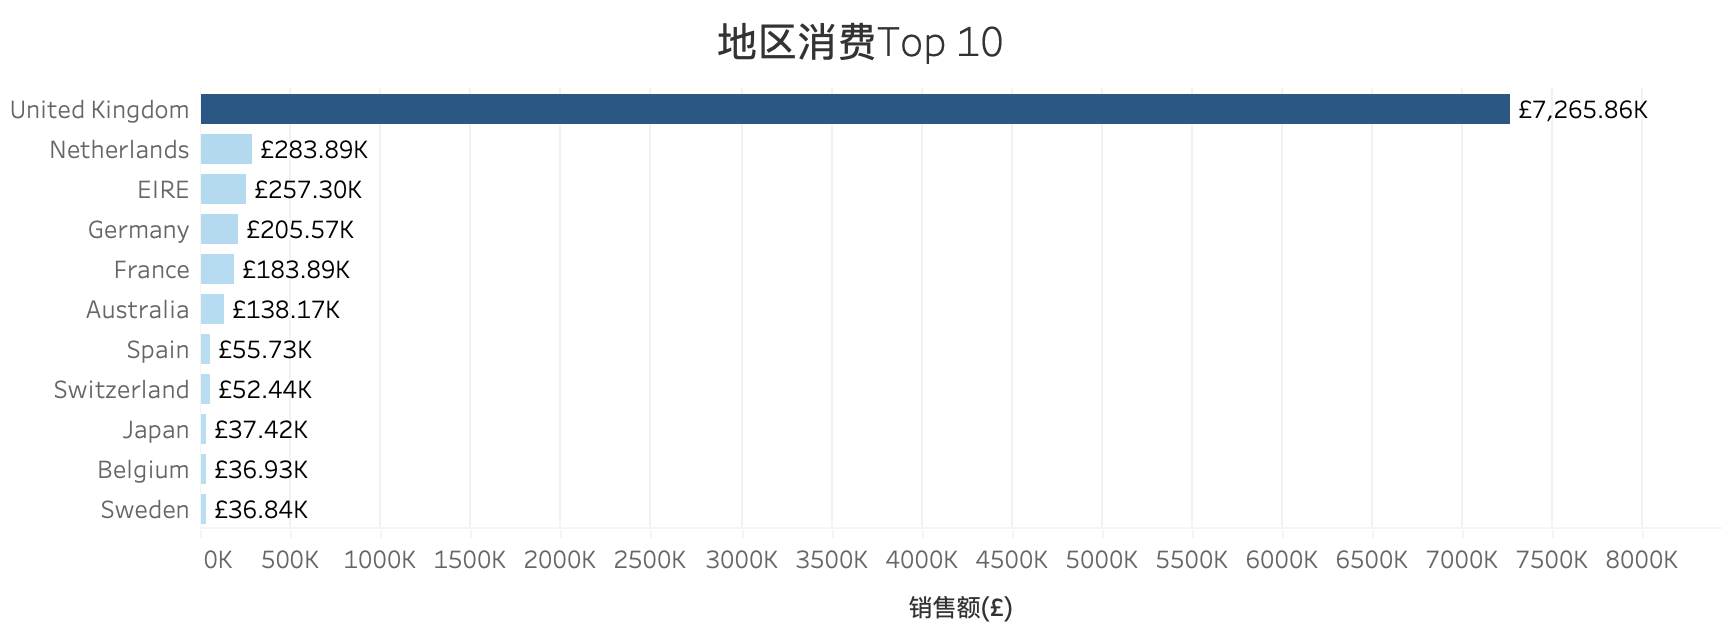

In [168]:
bar = (
    Bar()
    .add_xaxis(country_sales["Country"][:5].to_list())
    .add_yaxis("销售额", country_sales["TotalPrice"][:5].to_list(),label_opts = opts.LabelOpts(is_show=False))
    .add_yaxis("销量", country_salenum["Quantity"][:5].to_list(),label_opts = opts.LabelOpts(is_show=False))
    .set_global_opts(title_opts=opts.TitleOpts(title="不同国家销量 vs 销售额"))
)
bar.render_notebook()

由上图可知，英国本土的销量和销售额稳居于首位，是其他国家的几十倍。除英国外，销量和销售额排名前5名的其他国家分别是荷兰，爱尔兰，德国和法国，这些国家可作为国外收益增长的首选潜在市场，增加贸易往来，从而提高国外市场收益。

## 不同国家退货率

In [170]:
dc1 = data_canceled.groupby("Country")["Quantity"].sum().reset_index()
dc2 = dataset.groupby("Country")["Quantity"].sum().reset_index()
dc3 = pd.merge(dc1,dc2,on="Country")
dc3["ratio"] = dc3["Quantity_x"]/dc3["Quantity_y"]*100
dc3 = dc3.sort_values(by="ratio",ascending=False)

In [174]:
from pyecharts.charts import Line
Line = (
    Line()
    .add_xaxis(dc3["Country"][:5].to_list())
    .add_yaxis("退货率", dc3["ratio"][:5].to_list(),label_opts = opts.LabelOpts(is_show=False))
    .set_global_opts(title_opts=opts.TitleOpts(title="不同国家退货率"))
)
Line.render_notebook()

由上图可见，
 
   1. 美国的退货率稳居第一，退货率排名前5的其余国家分别为捷克，阿拉伯，英国和西班牙。
   
   2. 美国虽然客户数、销量和销售额都比较靠后，但是退货率却是最高的，说明美国客户的产品满意度较低。可以通过用户调研等方法，分析哪些产品需要改进，以逐步降低退货率。

   3. 除美国、捷克、阿拉伯和英国以外，其他国家退货率基本在5%以下，说明产品品质基本能够满足客户需求。

# 分析总结

1. 英国线上零售，主要集中于英国本土市场，销售额和销量在交易成功的37个国家中稳居首位，分别占比82.9%和82%。销售额和销量是其他国家的十    几倍，其他的消费主力军集中于欧洲市场，因此可以考虑开拓更多的市场渠道。

2. 时间轴上，2011年9月-11月时间段内，客户数量、销量和消费额均呈显著增长，考虑受促销活动和节假日等因素。同年12月，客户数量、销量和消费额则大幅度下降。

3. 产品销售上，销售和销量呈线性关系，23843、23166产品的销量、销售额虽然都较高，但是退货率同样较高，22423、85123A等产品的销量、销售额都比较高，退货率较低，可以增大产品的曝光率，进一步提高产品能带来的收益。

4. 从客户层面，客户的复购率和回购率以月为单位，总体比率分别高于19%和40%，说明客户的质量较高以及客户忠诚度良好。

